In [ ]:
! apt-get install default-jre
!java -version

In [ ]:
! pip install h2o

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
plt.style.use("bmh")

#training aux
from sklearn.model_selection import train_test_split

#models
import h2o
from h2o.estimators import H2ORandomForestEstimator

In [2]:
#df = pd.read_csv('data/ENEM_CLEAN.csv')
path = '/content/drive/MyDrive/analise_enem/data/ENEM_CLEAN_WITH_NAN.csv'
df = pd.read_csv(path)
df = df.loc[:, ~(df == 'FALTANTE').any()]

In [3]:
h2o.init()

h2o_df = h2o.H2OFrame(df)
for col in h2o_df.columns:
    if col[0:3] == 'CAT':
        h2o_df[col] = h2o_df[col].asfactor()

df_train, df_test = h2o_df.split_frame(ratios=[.8], seed=1)


results_path = '/content/drive/MyDrive/analise_enem/results/drf_numeric_categoric.csv'
drf_results = pd.read_csv(results_path, sep = ";").sort_values('score', ascending = False)
ntrees = drf_results.ntrees.iloc[0]
max_depth = drf_results.max_depth.iloc[0]

model = H2ORandomForestEstimator(
                                ntrees = int(ntrees),
                                max_depth = int(max_depth),
                                seed = 1
                                )            
model.train(x = [col for col in h2o_df.columns if col != 'NUM_NOTA'],
            y = 'NUM_NOTA',
            training_frame = df_train,
            validation_frame = df_test)
end = time.time()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbfwoesg1
  JVM stdout: /tmp/tmpbfwoesg1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpbfwoesg1/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_unknownUser_6363xk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.174 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [CAT_CADEIRA_CANHOTO, CAT_PROVA_DEITADO, CAT_CADEIRA_ESPECIAL]
  warnings.warn(mesg["message"], RuntimeWarning)


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [4]:
y_train_pred = model.predict(df_train)
y_test_pred = model.predict(df_test)
pd_df_train = df_train.as_data_frame()
pd_df_test = df_test.as_data_frame()
pd_y_train_pred = y_train_pred.as_data_frame()
pd_y_test_pred = y_test_pred.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


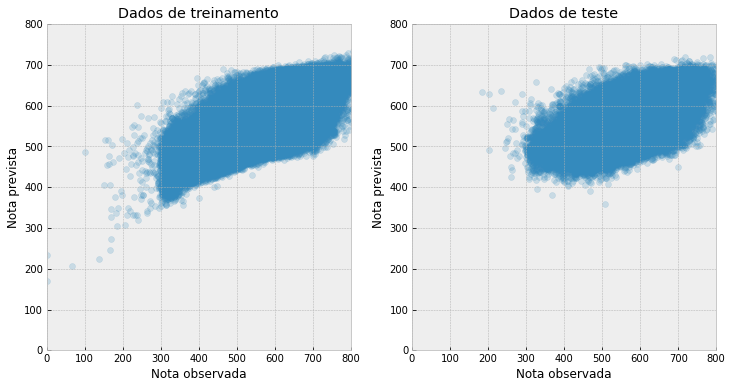

In [7]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 6))
ax[0].scatter(pd_df_train.NUM_NOTA, pd_y_train_pred, alpha = 0.2)
ax[1].scatter(pd_df_test.NUM_NOTA, pd_y_test_pred, alpha = 0.2)
ax[0].set_title(label = "Dados de treinamento")
ax[1].set_title(label = "Dados de teste")

for i in range(2):
    ax[i].set_xlim((0, 800))
    ax[i].set_ylim((0, 800))
    ax[i].set_ylabel('Nota prevista')
    ax[i].set_xlabel('Nota observada')
plt.show()

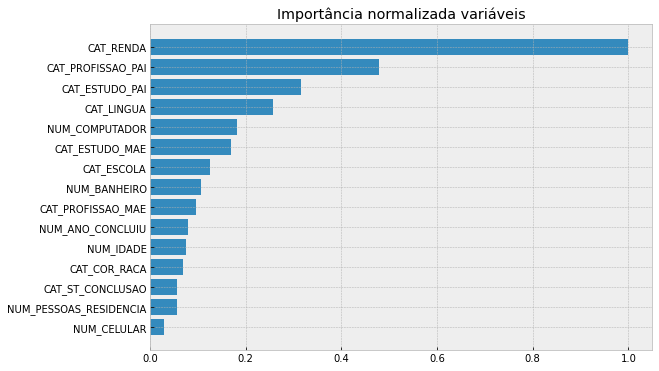

In [42]:
variable_importance = model.varimp(use_pandas= True)
fig = plt.figure(figsize = (9, 6))
y = variable_importance.variable.iloc[0:15].tolist()
y.reverse()

width = variable_importance.scaled_importance.iloc[0:15].tolist()
width.reverse()

plt.barh(y = y, width = width)
plt.title("Importância normalizada variáveis")
plt.show()

In [41]:
variable_importance = variable_importance.sort_values('scaled_importance')
variable_importance.head(50)

,variable,relative_importance,scaled_importance,percentage
82,CAT_SONDA,0.000000e+00,0.000000e+00,0.000000e+00
77,CAT_COMPUTADOR,0.000000e+00,0.000000e+00,0.000000e+00
78,CAT_MOBILIARIO_OBESO,0.000000e+00,0.000000e+00,0.000000e+00
81,CAT_MARCA_PASSO,0.000000e+00,0.000000e+00,0.000000e+00
80,CAT_PROTETOR_AURICULAR,0.000000e+00,0.000000e+00,0.000000e+00
79,CAT_LAMINA_OVERLAY,0.000000e+00,0.000000e+00,0.000000e+00
76,CAT_GUIA_INTERPRETE,4.536071e+02,1.942966e-08,5.688093e-09
75,CAT_SURDO_CEGUEIRA,8.141629e+03,3.487360e-07,1.020935e-07
74,CAT_MOBILIARIO_ESPECIFICO,7.885697e+04,3.377735e-06,9.888422e-07
73,CAT_GESTANTE,1.087339e+05,4.657474e-06,1.363490e-06


In [40]:
variable_importance.head(50)

,variable,relative_importance,scaled_importance,percentage
82,CAT_SONDA,0.000000e+00,0.000000e+00,0.000000e+00
77,CAT_COMPUTADOR,0.000000e+00,0.000000e+00,0.000000e+00
78,CAT_MOBILIARIO_OBESO,0.000000e+00,0.000000e+00,0.000000e+00
81,CAT_MARCA_PASSO,0.000000e+00,0.000000e+00,0.000000e+00
80,CAT_PROTETOR_AURICULAR,0.000000e+00,0.000000e+00,0.000000e+00
79,CAT_LAMINA_OVERLAY,0.000000e+00,0.000000e+00,0.000000e+00
76,CAT_GUIA_INTERPRETE,4.536071e+02,1.942966e-08,5.688093e-09
75,CAT_SURDO_CEGUEIRA,8.141629e+03,3.487360e-07,1.020935e-07
74,CAT_MOBILIARIO_ESPECIFICO,7.885697e+04,3.377735e-06,9.888422e-07
73,CAT_GESTANTE,1.087339e+05,4.657474e-06,1.363490e-06
